# Simple NN

Created by: Tiago Almeida 03/02/2018

In [1]:

##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data mnist

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


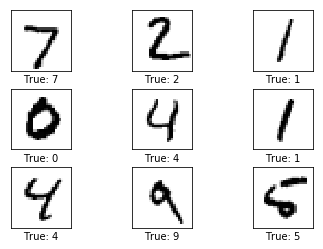

In [2]:

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data",one_hot=True)

#reset graph using during notebook development
tf.reset_default_graph()
ut.plot_mnist_images_label(mnist.test.images[0:9],np.argmax(mnist.test.labels[0:9],axis=1))

### CNN model

Here i will use the model in the tensorflow example

In [3]:
#Now the imput is the image it self no need to flat

X = tf.placeholder(tf.float32,shape=(None,784),name = "input")
X_reshape = tf.reshape(X, shape=[-1, 28, 28, 1])
Y = tf.placeholder(tf.float32,shape=(None,10),name = "y")
isTraining = tf.placeholder_with_default(False, shape=(), name='trainingPhase')

def classifier(x,train,name,drop_rate=0.5):
    '''
    Classifier network
    
    :param x: tensor with shape (M,28,28) here M = number of samples
    :param train: boolean tensor with indication if we are training or not
    :return: tensor with shape (M,10) corresponding to the logits
    '''
    with tf.name_scope("classifier_"+name):
        
        # Convolution Layer with 32 filters and a kernel size of (3,3)
        conv1 = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu,name="conv1_"+name)
        # Max Pooling (down-sampling) with strides of (2,2) and kernel size of (2,2)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2,name="pool1_"+name)

        # Convolution Layer with 64 filters and a kernel size of (3,3)
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu,name="conv2_"+name)
        # Max Pooling (down-sampling) with strides of (2,2) and kernel size of (2,2)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2,name="pool1_"+name)

        # Flatten the data
        fc1 = tf.layers.flatten(conv2,name="flatten_"+name)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024,name="fc1_"+name)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=drop_rate, training=train,name="dropout1_"+name)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, 10,name="output_"+name)

        return out

clf_cnn = classifier(X_reshape,isTraining,"clf_cnn")

with tf.name_scope("loss_cnn"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=clf_cnn)
    loss_cnn = tf.reduce_mean(xentropy)

lr = 0.001
with tf.name_scope("train_cnn"):
    clf_cnn_variables = [var for var in tf.trainable_variables() if 'clf_cnn' in var.name] #this line is optional but i want to keep consistence
    train_cnn_op = tf.train.AdamOptimizer(lr).minimize(loss_cnn,var_list=clf_cnn_variables)
    
with tf.name_scope("predict_cnn"):
    predict_cnn = tf.argmax(clf_cnn, 1)
    #i am calculate a acc with numpy since i need to use batch iterations for test set (no need to do in tf) 
    acc_cnn = tf.reduce_mean(tf.cast(tf.equal(predict_cnn, tf.argmax(Y, 1)), tf.float32))

#since i am using gpu i need to run the test set in batchs
def acc(x,labels):
    '''
    Calculate the accuracy of test set, since i need to run it in batchs (gpu menory issues)
    
    :param x: tensor with shape (M,28,28) here M = number of samples
    :param train: boolean tensor with indication if we are training or not
    :return: tensor with shape (M,10) corresponding to the logits
    '''
    test_size = mnist.test.num_examples
    
    predict = np.zeros(shape=test_size, dtype=np.int)
    
    #list with start and end index for batch iteration
    test_batch = zip(range(0, test_size, batch_size), range(batch_size, test_size + 1, batch_size))
    
    for start,end in test_batch:
        predict[start:end] = predict_cnn.eval(session=sess,feed_dict={X:x[start:end]})
    
    return np.mean(predict==labels), predict
        

### It's trainning time

[7 2 1 ..., 4 5 6]
Epoach: 0 Loss: 2.28578
Acc: 0.2751
[2 0 4 ..., 4 5 6]


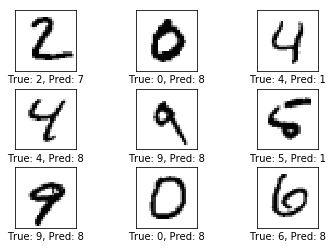

Epoach: 200 Loss: 0.196678
Acc: 0.9725
[4 6 2 9 2 2 5 8 2 6 2 8 4 8 2 1 2 7 4 0 4 4 8 7 2 2 8 4 5 6 7 6 3 4 3 7 6
 6 0 7 4 9 2 7 5 8 7 5 2 7 7 8 7 0 2 3 9 2 7 2 8 9 7 5 4 7 2 3 4 6 4 1 0 2
 9 8 3 0 9 8 9 2 4 6 2 2 4 7 4 2 6 4 2 5 8 3 3 8 6 6 9 1 8 8 8 2 7 2 6 3 9
 2 6 5 8 9 4 2 4 4 7 5 2 5 7 6 5 1 2 8 8 9 7 2 2 9 2 4 2 3 2 5 5 3 8 9 2 6
 6 4 6 8 2 8 3 5 4 8 4 9 2 0 4 8 8 3 4 4 8 8 7 2 1 3 6 7 4 5 3 5 3 5 5 5 2
 5 9 2 9 9 8 9 8 7 0 8 8 0 5 8 7 2 6 2 8 8 7 4 4 2 2 1 1 5 2 1 7 7 7 1 2 2
 2 2 2 2 5 2 0 6 8 4 4 7 7 7 1 1 2 2 3 2 6 2 2 5 5 2 5 2 4 2 2 2 9 2 2 2 3
 5 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6]


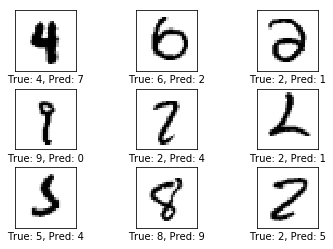

KeyboardInterrupt: 

In [5]:
batch_size = 128
epoach = 10000

#tensorflow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

label_class = np.argmax(mnist.test.labels,axis=1)

for i in range(epoach):
    
    x_train,y_train = mnist.train.next_batch(batch_size=batch_size)
    
    _,it_loss = sess.run([train_cnn_op,loss_cnn], feed_dict = {X:x_train, Y:y_train, isTraining:True })
    
    if i%200==0:
        print("Epoach:",i,"Loss:",it_loss)
        accuracy,pred = acc(mnist.test.images,label_class)
        miss_clf = pred!=label_class
        print("Acc:",accuracy)
        
        #find miss classification
        ut.plot_mnist_images_label(mnist.test.images[miss_clf][0:9],label_class[miss_clf][0:9],cls_pred=pred)
        
        
    

In [ ]:
sess.close()